# Analyzing customer messages

This notebook demonstrates analyzing customer messages using Watson Natural Language Understanding.

**Section A**
1. Install/import libraries
2. Load sample customer messages
3. Authenticate with Watson Natural Language Understanding

**Section B**
4. Analyze sample messages using default models
5. Visualize results

**Section C**
6. Analyze sample messages using a custom model
7. Normalize results
8. Compare general results with custom results

## Section A

In this section, we'll get everything set up.

1. Install/import libraries
2. Load sample customer messages
3. Authenticate with Watson Natural Language Understanding

### 1. Install/import libraries

- `ibm-watson` is needed so we can use Watson Natural Language Understanding
- `wordcloud` is needed so we can visualize our results in word clouds
- `CASCON_replay_sample_functions.py` contains convenience functions (to save us time in the workshop)

In [ ]:
!pip install ibm-watson

In [ ]:
!pip install wordcloud

In [16]:
from requests import get
local_file_name = "CASCON_replay_sample_functions.py"
url = "https://raw.githubusercontent.com/spackows/CASCON-2019_NLP-workshops/master/2020-replay/CASCON-replay-sample-functions.py"
with open( local_file_name, "wb") as file:
    response = get( url )
    file.write( response.content )
import CASCON_replay_sample_functions as workshop

### 2. Load sample customer messages

This sample data set is from the Watson Studio Gallery: [Customer messages](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/015ddef6a868441188268a123404f744)

These messages are not _real_ customer messages.  But they were created based on real messages received in live chat and chatbot.

In [2]:
# Import the data into a DataFrame by reading from a URL
#
import pandas as pd
import io
import requests
url = "https://api.dataplatform.cloud.ibm.com/v2/gallery-assets/entries/015ddef6a868441188268a123404f744/data?accessKey=1e878a1edda3c1c8b3f9defb83e5c84b"
csv_contents = io.StringIO( requests.get( url ).content.decode( "utf-8" ) )
all_messages = pd.read_csv( csv_contents, header=None )
all_messages.head()

,0,1
0,excuse me,hi
1,Good evening,hi
2,Good morning,hi
3,good morning,hi
4,Good morning can you help me upload a shapefile?,question


In [3]:
# For analysis purposes, we want just the questions and problems, 
# not the short, social messages labeled as "hi". And we want just 
# the text of those questions and problems, not the labels column.
#
questions_problems_only = all_messages[all_messages.iloc[:,1] != "hi" ].reset_index(drop=True)
questions_problems_text = list( questions_problems_only.iloc[:,0] )
questions_problems_text[0:6]

['Good morning can you help me upload a shapefile?',
 'Good night where to place my file to import it into notebook?',
 'hai how can i do analyze with csv file is there any tutorial on it',
 'Having issues setup WML service',
 'hello - Im trying to edit a notebook and the circie just keeps spinning. any idea to get around this?',
 'hello how can i download a csv file from my notebook?']

### 3. Authenticate with Watson Natural Language Understanding

In this workshop, we'll be using the [Watson Natural Language Understanding API](https://cloud.ibm.com/apidocs/natural-language-understanding)

In [4]:
import json
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_watson.natural_language_understanding_v1 import Features, ConceptsOptions, EmotionOptions, EntitiesOptions, KeywordsOptions, SemanticRolesOptions, SentimentOptions, CategoriesOptions, SyntaxOptions, SyntaxOptionsTokens
apikey = ""
url = ""
custom_model_id = ""
authenticator = IAMAuthenticator( apikey )
nlu = NaturalLanguageUnderstandingV1( version='2018-11-16', authenticator=authenticator )
nlu.set_service_url( url )

## Section B

A great way to learn about Watson Natural Language is the [Demo app](https://natural-language-understanding-demo.ng.bluemix.net).

In section B, we'll use the API to extract keywords and semantic roles.

4. Analyze sample messages using default models
5. Visualize results

### 4. Analyze sample messages using default models

Use the [analyze](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#analyze-text) function.

In [5]:
# Analyze a single message using the API directly
#
text = "Hi I wanted to know how to export data from python notebooks?"
default_result = nlu.analyze( text=text, features=Features( keywords=KeywordsOptions(), semantic_roles=SemanticRolesOptions() ) ).get_result()
print( '"' + text + '"' + "\n" )
default_result

"Hi I wanted to know how to export data from python notebooks?"



{'usage': {'text_units': 1, 'text_characters': 61, 'features': 2},
 'semantic_roles': [{'subject': {'text': 'I'},
   'sentence': 'Hi I wanted to know how to export data from python notebooks?',
   'object': {'text': 'to know how to export data from python notebooks'},
   'action': {'verb': {'text': 'want', 'tense': 'past'},
    'text': 'wanted',
    'normalized': 'want'}},
  {'subject': {'text': 'I'},
   'sentence': 'Hi I wanted to know how to export data from python notebooks?',
   'object': {'text': 'how to export data from python notebooks'},
   'action': {'verb': {'text': 'know', 'tense': 'future'},
    'text': 'wanted to know',
    'normalized': 'want to know'}},
  {'subject': {'text': 'I'},
   'sentence': 'Hi I wanted to know how to export data from python notebooks?',
   'object': {'text': 'data'},
   'action': {'verb': {'text': 'export', 'tense': 'future'},
    'text': 'to export',
    'normalized': 'to export'}}],
 'language': 'en',
 'keywords': [{'text': 'python notebooks', '

In [6]:
# Use a convenience function to loop through sample 
# customer messages, performing analysis using the API
#
default_results_list = workshop.analyzeSampleMessages_Default( questions_problems_text, nlu )
default_results_list[0:3]

[{'header': '-------------------------------------------------------------',
  'message': 'Good morning can you help me upload a shapefile?',
  'actions': ['help'],
  'keywords': ['Good morning', 'shapefile'],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'Good night where to place my file to import it into notebook?',
  'actions': ['to place', 'to import'],
  'keywords': ['Good night', 'file', 'notebook'],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'hai how can i do analyze with csv file is there any tutorial on it',
  'actions': ['do', 'be'],
  'keywords': ['csv file', 'hai', 'tutorial'],
  'spacer': ''}]

### 5. Visualize results

- Use the [word cloud](https://github.com/amueller/word_cloud/blob/master/README.md) library to display action words and keywords extracted from the sample messages

- Also display results using bar charts

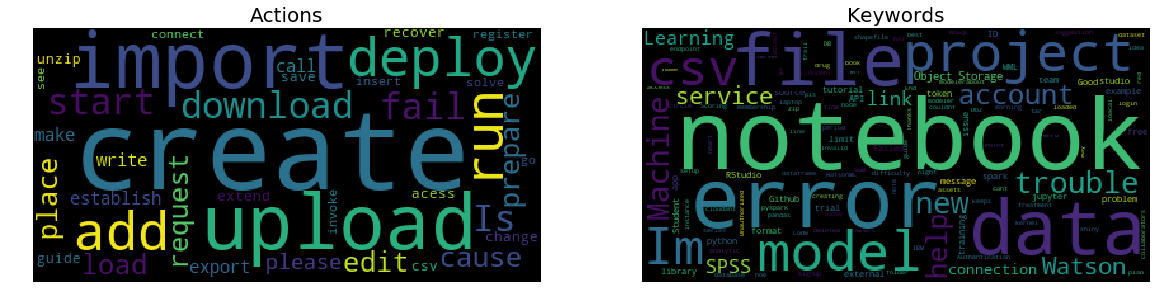

In [7]:
# Use a helper function to count the extracted words,
# call the word cloud library function, and then plot results
#
workshop.plotWordCloud( default_results_list )

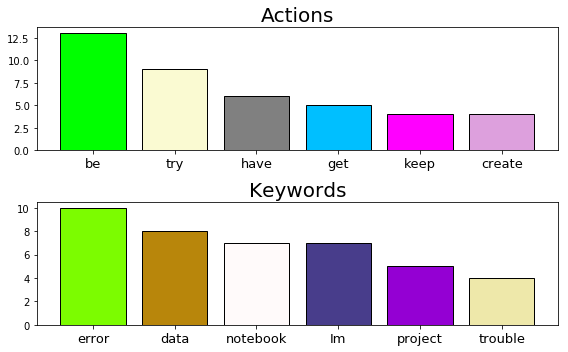

In [8]:
# Use a helper function to count the extracted words,
# and then plot bar charts
#
workshop.plotDefaultCharts( default_results_list )

## Section C

In the word clouds and bar charts above, analysis is hampered by the fact that the default NLU language models have pulled out common verbs, which are not technical enough for our analysis.

Our sample customer messages contain Watson Studio-specific terminology and jargon. So, for the purposes of analyzing these sample messages, we need a custom language model that understands action words like "import" and "deploy" have special importance...

6. Analyze sample messages using a custom model
7. Normalize results
8. Compare general results with custom results

### 6. Analyze sample messages using a custom model

In this workshop, we'll be using a custom language model that was created using [Watson Knowledge Studio](https://cloud.ibm.com/catalog/services/knowledge-studio).  This custom model was created beforehand to save time in the workshop.

If you are interested to learn how to create this custom language model, you can follow these instructions: [CASCON 2019 - NLP workshops, day 2](https://github.com/spackows/CASCON-2019_NLP-workshops/blob/master/Workshop-2-Tuesday.md)


In [9]:
# Analyze a single message using the API directly
#
# Notice: This is the same as the code above, 
# with the addition of specifying the custom model ID
#
custom_result = nlu.analyze( text=text, features=Features( entities=EntitiesOptions( model=custom_model_id ) ) ).get_result()
print( '"' + text + '"' + "\n" )
custom_result

"Hi I wanted to know how to export data from python notebooks?"



{'usage': {'text_units': 1, 'text_characters': 61, 'features': 1},
 'language': 'en',
 'entities': [{'type': 'action',
   'text': 'export',
   'disambiguation': {'subtype': ['NONE']},
   'count': 1,
   'confidence': 0.99987},
  {'type': 'tech',
   'text': 'python',
   'disambiguation': {'subtype': ['NONE']},
   'count': 1,
   'confidence': 0.99972},
  {'type': 'obj',
   'text': 'notebooks',
   'disambiguation': {'subtype': ['NONE']},
   'count': 1,
   'confidence': 0.999389}]}

In [10]:
# Use a convenience function to compare the previous results
# from the default model with results from the custom model
#
workshop.compareResults( text, default_result, custom_result )

Text: "Hi I wanted to know how to export data from python notebooks?"

Default keywords: [ 'python notebooks', 'data' ]
Default actions: [ 'want', 'want to know', 'to export' ]


Custom actions: [ 'export' ]
Custom objects: [ 'notebooks' ]
Custom technology: [ 'python' ]


In [11]:
# Use a convenience function to loop through sample 
# customer messages, performing analysis using the API
#
custom_results_list = workshop.analyzeSampleMessages_Custom( questions_problems_text, nlu, custom_model_id )
custom_results_list[0:3]

[{'header': '-------------------------------------------------------------',
  'message': 'Good morning can you help me upload a shapefile?',
  'actions': ['upload'],
  'objects': ['shapefile'],
  'tech': [],
  'docs': [],
  'persona': [],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'Good night where to place my file to import it into notebook?',
  'actions': ['import'],
  'objects': ['notebook'],
  'tech': [],
  'docs': [],
  'persona': [],
  'spacer': ''},
 {'header': '-------------------------------------------------------------',
  'message': 'hai how can i do analyze with csv file is there any tutorial on it',
  'actions': ['analyze'],
  'objects': [],
  'tech': [],
  'docs': ['tutorial'],
  'persona': [],
  'spacer': ''}]

### 7. Normalize results

When we count the words to visualize results, notice the repetition: "create" and "creating" are counted as separate entities. But for our analysis purposes, those both refer to the same action. Instead of being counted separately, they should be counted together.

We need to normalize these results before they can be most useful.

Here' we'll use a convenience function to normalize these results.  For a more complete discussion of how this normalization is achieved, you can follow these instructions: [CASCON 2019 - NLP workshops, day 2](https://github.com/spackows/CASCON-2019_NLP-workshops/blob/master/Workshop-2-Tuesday.md)

In [12]:
# Use a convenience function to count the 
# instances of words in the custom results
#
workshop.countWords( custom_results_list, "actions", 1 )

OrderedDict([('create', 10),
             ('upload', 5),
             ('import', 3),
             ('download', 3),
             ('deployed', 3),
             ('creating', 3),
             ('add', 3),
             ('connection', 3),
             ('training', 2),
             ('export', 2),
             ('deploy', 2)])

In [13]:
# Use a convenience function to normalize the results
#
normalized_custom_results_list = workshop.normalize( custom_results_list )
normalized_custom_results_list[0]

{'header': '-------------------------------------------------------------',
 'message': 'Good morning can you help me upload a shapefile?',
 'actions': ['load'],
 'objects': ['shapefile'],
 'tech': [],
 'docs': [],
 'persona': [],
 'spacer': ''}

In [14]:
# Use a convenience function to count the 
# instances of words in the normalized, custom results
#
workshop.countWords( normalized_custom_results_list, "actions", 1 )

OrderedDict([('create', 14),
             ('load', 7),
             ('deploy', 5),
             ('import', 4),
             ('connect', 4),
             ('download', 3),
             ('add', 3),
             ('access', 2),
             ('train', 2),
             ('export', 2),
             ('sign up', 2)])

### 7. Visualize results

Display default results and normalized, custom results using bar charts.

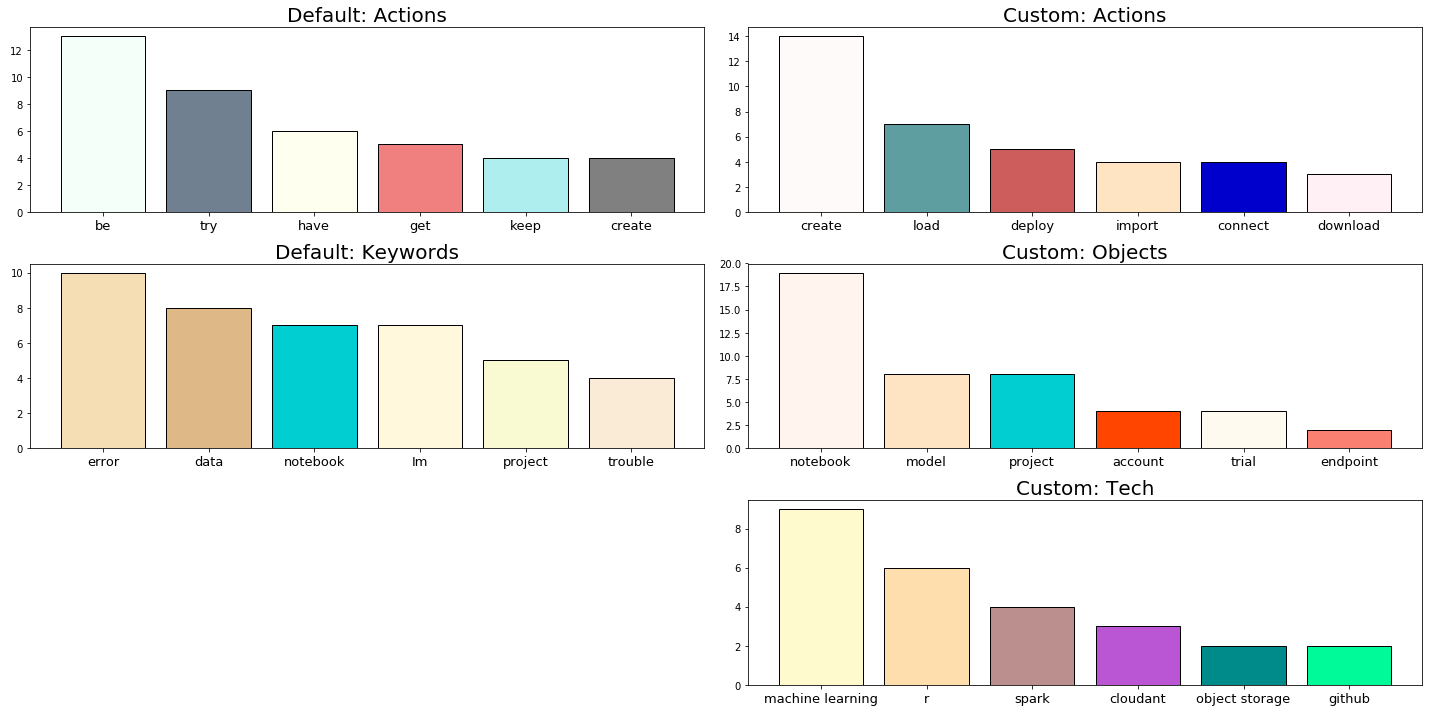

In [15]:
# Use a helper function to count the extracted words,
# and then plot bar charts
#
workshop.plotAllCharts( default_results_list, normalized_custom_results_list )

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.